In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

In [2]:
# Running funciones_borrador.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_borrador/IGW_BAR/funciones_borrador.ipynb

## Loading Data

In [3]:
# Loading ssh_hf and making and selecting 1h for testing
ssh_hf = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_01.nc")
ssh_hf_1h = ssh_hf.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=pd.to_datetime('2014-01-10T00:30:00')).load()

# Appying the mask to ssh_hf_1h, keep data where mask is equal to 1
mask = xr.open_dataset('/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc',drop_variables={"x","y"}) 
ssh_hf_1h_masked = ssh_hf_1h['ssh_hf'].where(mask.tmaskutil[0,:,:] == 1, np.nan).load()

In [4]:
dx = dy = 1.7 #km

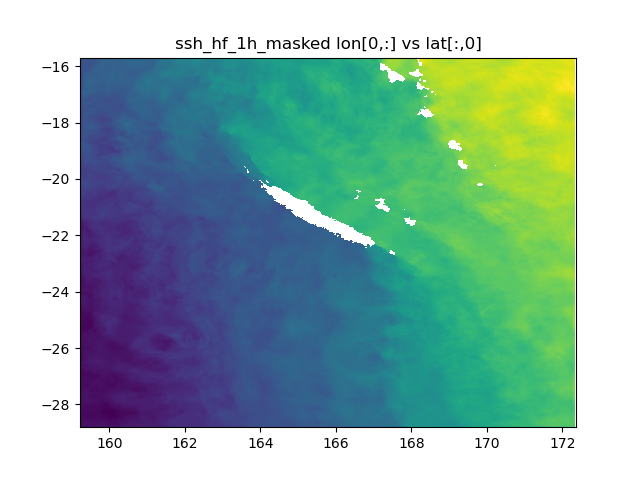

In [30]:
plt.figure()
plt.pcolormesh(ssh_hf_1h_masked.lon[0,:], ssh_hf_1h_masked.lat[:,0], ssh_hf_1h_masked)
plt.title('ssh_hf_1h_masked lon[0,:] vs lat[:,0]')
plt.show()

In [7]:
# Assuming `ssh_hf_1h_masked` is your original DataArray
lon_1d = ssh_hf_1h_masked.lon[0, :].data  # Extract the data from the DataArray
lat_1d = ssh_hf_1h_masked.lat[:, 0].data  # Extract the data from the DataArray

# Create a new DataArray
new_data_array = xr.DataArray(
    data=ssh_hf_1h_masked.data,  # Use the original data or any transformed version
    dims=["y", "x"],  # Keep original dimensions or adjust as necessary
    coords={
        "lat": (("y", "x"), ssh_hf_1h_masked.lat.data),
        "lon": (("y", "x"), ssh_hf_1h_masked.lon.data)
    },
    attrs=ssh_hf_1h_masked.attrs  # Optionally include attributes from the original array
)

# Store 1D coordinates in the new DataArray correctly
new_data_array.coords['lon_1d'] = ('x', lon_1d)
new_data_array.coords['lat_1d'] = ('y', lat_1d)

# Drop the 'lon' and 'lat' coordinates
new_data_array = new_data_array.drop_vars(['lon', 'lat'])

# Optionally, if you've created new 1D coordinates and want to set them, do it after dropping
new_data_array = new_data_array.assign_coords(lon_1d=('x', lon_1d), lat_1d=('y', lat_1d))


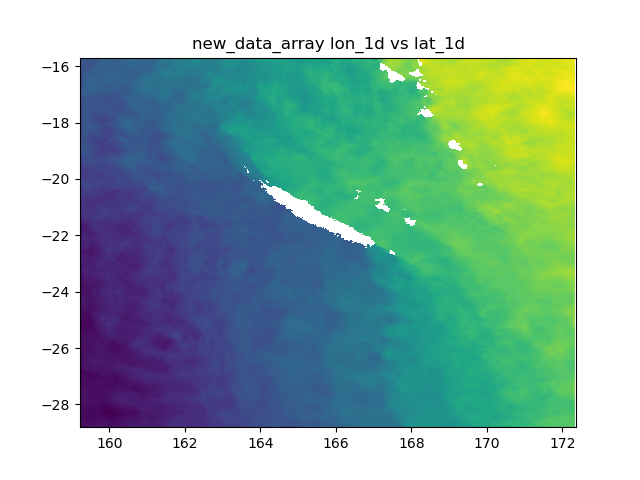

In [32]:
plt.figure()
plt.pcolormesh(new_data_array.lon_1d, new_data_array.lat_1d, new_data_array)
plt.title('new_data_array lon_1d vs lat_1d')
plt.show()

In [33]:
# Filter
date_to_process = '2014-01-10T00:30:00'
lambda_value = 400  # km
ssh_igw, ssh_bar = bar_igw_filter(date_to_process, lambda_bar=lambda_value)

In [12]:
ssh_hf_1h_masked_regular = transform_to_regular_grid(ssh_hf_1h_masked)

In [13]:
# Create an xarray DataArray for ssh_igw using the coordinates from ssh_hf_1h_masked_regular
ssh_igw_da = xr.DataArray(ssh_igw, coords=[ssh_hf_1h_masked_regular.coords['y'], ssh_hf_1h_masked_regular.coords['x']], dims=['y', 'x'])

In [14]:
# Confirm the shapes
ssh_hf_1h_masked_regular.shape, ssh_igw_da.shape

((867, 829), (867, 829))

In [15]:
# Invert the NaN mask, where 'False' will be where ssh_hf_1h_masked_regular is NaN
not_nan_mask = ~np.isnan(ssh_hf_1h_masked_regular)

# Apply this inverted mask using 'where' to keep NaNs in ssh_igw_da where ssh_hf_1h_masked_regular is NaN
ssh_igw_masked = ssh_igw_da.where(not_nan_mask, np.nan)

In [35]:
ssh_igw_masked = ssh_igw_masked.rename({'y': 'lat_1d', 'x': 'lon_1d'})

In [36]:
ssh_igw_masked

<xarray.DataArray (lat_1d: 867, lon_1d: 829)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat_1d   (lat_1d) float64 7kB 6.791e+03 6.793e+03 ... 8.262e+03 8.264e+03
  * lon_1d   (lon_1d) float64 7kB -118.8 -117.1 -115.4 ... 1.287e+03 1.289e+03

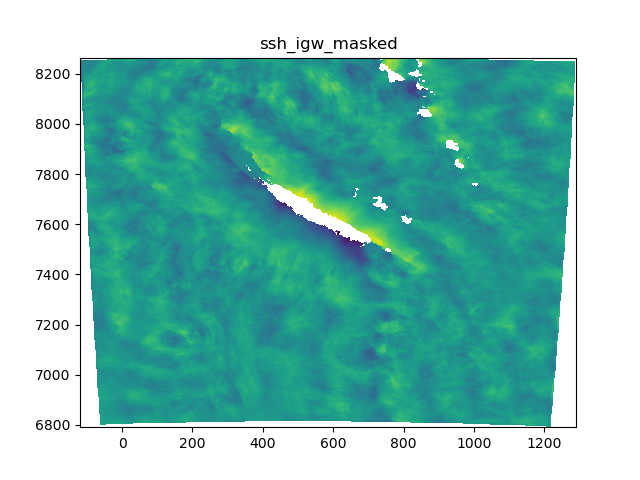

In [42]:
plt.figure()
plt.pcolormesh(ssh_igw_masked.lon_1d, ssh_igw_masked.lat_1d, ssh_igw_masked, shading='auto')
plt.title('ssh_igw_masked')
plt.show()

Refrence point

In [44]:
# Extract x and y coordinates (assuming they are stored in the dataset)
x = ssh_hf_1h_masked_regular.x.values
y = ssh_hf_1h_masked_regular.y.values

# Set up the UTM Zone 58S projection for WGS84
proj_utm = Proj(proj='utm', zone=58, south=True, ellps='WGS84')

# Assuming the lower-left corner as the reference point
x_min, y_min = x.min(), y.min()

# Convert the minimum UTM coordinates back to geographic coordinates
lon_min, lat_min = proj_utm(x_min * 1000, y_min * 1000, inverse=True)

reference_point = {'longitude': lon_min, 'latitude': lat_min}
reference_point


{'longitude': 158.6626135863296, 'latitude': -28.855551581371003}

In [48]:
# Load the datasets
regular_data = ssh_hf_1h_masked_regular 
original_data = ssh_hf_1h_masked 

In [49]:
regular_data

<xarray.DataArray (y: 867, x: 829)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 7kB 6.791e+03 6.793e+03 ... 8.262e+03 8.264e+03
  * x        (x) float64 7kB -118.8 -117.1 -115.4 ... 1.287e+03 1.289e+03

In [51]:
# Get latitude and longitude from the original dataset
lat_original = original_data.lat.values
lon_original = original_data.lon.values

# If these are 1D, convert them to 2D using meshgrid
if lat_original.ndim == 1 or lon_original.ndim == 1:
    lon_original, lat_original = np.meshgrid(lon_original, lat_original)

# Set up the UTM Zone 58S projection for WGS84
proj_utm = Proj(proj='utm', zone=58, south=True, ellps='WGS84')
transformer = Transformer.from_proj(proj_utm, proj_utm, always_xy=True)

# Convert original geographic coordinates to UTM coordinates
x_original, y_original = transformer.transform(lon_original, lat_original)

# Extract the regular grid data and coordinates
values_regular = regular_data.values  # Replace 'variable_name' with the correct variable
X_regular = regular_data.x.values * 1000  # Assuming stored in km in the file
Y_regular = regular_data.y.values * 1000

# Flatten the regular grid coordinates and data
X_regular_flat = X_regular.flatten()
Y_regular_flat = Y_regular.flatten()
values_regular_flat = values_regular.flatten()

# Interpolate from the regular grid back to the original grid
interpolated_values = griddata(
    (X_regular_flat, Y_regular_flat),
    values_regular_flat,
    (x_original, y_original),
    method='cubic'  # You might choose 'linear' or 'nearest' depending on data characteristics
)

# Create a new xarray DataArray or Dataset with the interpolated values
interpolated_data = xr.DataArray(
    interpolated_values,
    coords=[('lat', original_data.lat), ('lon', original_data.lon)],
    dims=['lat', 'lon']
)



ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (829,) and arg 1 with shape (867,).

In [52]:
# Check if coordinate transformations are correct
print(f"Shape of original latitude grid: {lat_original.shape}")
print(f"Shape of original longitude grid: {lon_original.shape}")
print(f"Shape of x_original (UTM): {x_original.shape}")
print(f"Shape of y_original (UTM): {y_original.shape}")

# Ensure correct transformation and grid alignment
if lat_original.shape != lon_original.shape:
    print("Latitude and longitude arrays do not form a proper grid.")
else:
    print("Latitude and longitude arrays are properly aligned.")

# Attempt interpolation only if the shapes match
if x_original.shape == y_original.shape:
    interpolated_values = griddata(
        (X_regular_flat, Y_regular_flat),
        values_regular_flat,
        (x_original.flatten(), y_original.flatten()),
        method='cubic'  # Adjust method as needed
    )
else:
    print("Mismatch in grid dimensions, interpolation cannot proceed.")

Shape of original latitude grid: (853, 788)
Shape of original longitude grid: (853, 788)
Shape of x_original (UTM): (853, 788)
Shape of y_original (UTM): (853, 788)
Latitude and longitude arrays are properly aligned.


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (829,) and arg 1 with shape (867,).

In [53]:
# Verify shapes and content before interpolation
print(f"Shape of flattened X_regular: {X_regular_flat.shape}")
print(f"Shape of flattened Y_regular: {Y_regular_flat.shape}")

# Print a small sample to inspect
print("Sample data from X_regular_flat:", X_regular_flat[:10])
print("Sample data from Y_regular_flat:", Y_regular_flat[:10])

# Create the target grid properly
target_grid = np.column_stack((x_original.flatten(), y_original.flatten()))

# Check shapes and compatibility
print(f"Shape of target grid for interpolation: {target_grid.shape}")

# Attempt interpolation only if the shapes match and configurations are correct
try:
    interpolated_values = griddata(
        points=(X_regular_flat, Y_regular_flat),
        values=values_regular_flat,
        xi=target_grid,
        method='cubic'  # Adjust method as needed
    )

    # Create a new xarray DataArray or Dataset with the interpolated values
    interpolated_data = xr.DataArray(
        interpolated_values,
        coords=[('lat', original_data.lat), ('lon', original_data.lon)],
        dims=['lat', 'lon']
    )

    print("Interpolation successful.")

except Exception as e:
    print(f"Interpolation failed: {e}")


Shape of flattened X_regular: (829,)
Shape of flattened Y_regular: (867,)
Sample data from X_regular_flat: [-118795.31027908 -117095.31027908 -115395.31027908 -113695.31027908
 -111995.31027908 -110295.31027908 -108595.31027908 -106895.31027908
 -105195.31027908 -103495.31027908]
Sample data from Y_regular_flat: [6791458.9709177 6793158.9709177 6794858.9709177 6796558.9709177
 6798258.9709177 6799958.9709177 6801658.9709177 6803358.9709177
 6805058.9709177 6806758.9709177]
Shape of target grid for interpolation: (672164, 2)
Interpolation failed: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (829,) and arg 1 with shape (867,).


In [54]:
# Assuming the correct shapes for X_regular and Y_regular from previous outputs
# Reconstruct the full meshgrid from X_regular and Y_regular
X_mesh, Y_mesh = np.meshgrid(X_regular_flat, Y_regular_flat)
X_mesh_flat = X_mesh.flatten()
Y_mesh_flat = Y_mesh.flatten()

# Since the shape of the target grid looks good, let's use it directly
target_grid = np.column_stack((x_original.flatten(), y_original.flatten()))

# Perform the interpolation
interpolated_values = griddata(
    points=(X_mesh_flat, Y_mesh_flat),
    values=values_regular_flat,  # Ensure this is also correctly shaped; it must match the size of X_mesh_flat and Y_mesh_flat
    xi=target_grid,
    method='cubic'  # Choose 'linear' or 'nearest' if 'cubic' causes issues with NaNs or infinities
)

# Check if interpolation was successful
if interpolated_values is not None:
    print("Interpolation successful.")
else:
    print("Interpolation failed.")

Interpolation successful.


In [55]:
interpolated_values

array([nan, nan, nan, ..., nan, nan, nan])

In [59]:
# Get latitude and longitude from the original dataset
lat_original = original_data.lat.values
lon_original = original_data.lon.values

# If these are 1D, convert them to 2D using meshgrid
if lat_original.ndim == 1 or lon_original.ndim == 1:
    lon_original, lat_original = np.meshgrid(lon_original, lat_original)

# Set up the UTM Zone 58S projection for WGS84
proj_utm = Proj(proj='utm', zone=58, south=True, ellps='WGS84')
transformer = Transformer.from_proj(proj_utm, proj_utm, always_xy=True)

# Convert original geographic coordinates to UTM coordinates
x_original, y_original = transformer.transform(lon_original.flatten(), lat_original.flatten())

# Extract the regular grid data and coordinates
values_regular = regular_data.values  # Replace 'variable_name' with the correct variable
X_regular = regular_data.x.values * 1000  # Assuming stored in km in the file
Y_regular = regular_data.y.values * 1000

# Flatten the regular grid coordinates and data
X_regular_flat = X_regular.flatten()
Y_regular_flat = Y_regular.flatten()
values_regular_flat = values_regular.flatten()

# Form the target meshgrid for interpolation (similar to how source meshgrid was formed)
x_target_mesh, y_target_mesh = np.meshgrid(x_original, y_original)

# Perform the interpolation using the 2D grid coordinates
interpolated_values = griddata(
    points=(X_mesh_flat, Y_mesh_flat),
    values=values_regular_flat,
    xi=(x_target_mesh, y_target_mesh),
    method='cubic'  # 'linear' or 'nearest' might be more stable
)

# Reshape the interpolated values to match the dimensions of the target grid
interpolated_values_reshaped = interpolated_values.reshape(x_target_mesh.shape)

# Create a new xarray DataArray with the reshaped interpolated values
interpolated_data = xr.DataArray(
    interpolated_values_reshaped,
    coords={'lat': (('lat', 'lon'), lat_original), 'lon': (('lat', 'lon'), lon_original)},
    dims=['lat', 'lon']
)

MemoryError: Unable to allocate 3.29 TiB for an array with shape (672164, 672164) and data type float64

In [64]:
# Get latitude and longitude from the original dataset
lat_original = original_data.lat.values
lon_original = original_data.lon.values

# If these are 1D, convert them to 2D using meshgrid
if lat_original.ndim == 1 or lon_original.ndim == 1:
    lon_original, lat_original = np.meshgrid(lon_original, lat_original)

# Set up the UTM Zone 58S projection for WGS84
proj_utm = Proj(proj='utm', zone=58, south=True, ellps='WGS84')
transformer = Transformer.from_proj(proj_utm, proj_utm, always_xy=True)

# Convert original geographic coordinates to UTM coordinates
x_original, y_original = transformer.transform(lon_original.flatten(), lat_original.flatten())

# Extract the regular grid data and coordinates
values_regular = regular_data.values  # Replace 'variable_name' with the correct variable
X_regular = regular_data.x.values * 1000  # Assuming stored in km in the file
Y_regular = regular_data.y.values * 1000

# Flatten the regular grid coordinates and data
X_regular_flat = X_regular.flatten()
Y_regular_flat = Y_regular.flatten()
values_regular_flat = values_regular.flatten()

# Form the complete meshgrid from regular data coordinates
X_mesh, Y_mesh = np.meshgrid(X_regular, Y_regular)
X_mesh_flat = X_mesh.flatten()
Y_mesh_flat = Y_mesh.flatten()

# Define a sparse grid for the target coordinates due to memory constraints
num_points = 1000  # Define a reasonable number of points based on available memory
x_target_sparse, y_target_sparse = np.meshgrid(
    np.linspace(np.min(x_original), np.max(x_original), num=num_points),
    np.linspace(np.min(y_original), np.max(y_original), num=num_points)
)

# Perform the interpolation using the 2D grid coordinates
interpolated_values = griddata(
    points=(X_mesh_flat, Y_mesh_flat),
    values=values_regular_flat,
    xi=(x_target_sparse.flatten(), y_target_sparse.flatten()),
    method='linear'  # 'linear' or 'nearest' might be more stable
)

# Reshape the interpolated values to match the dimensions of the sparse target grid
interpolated_values_reshaped = interpolated_values.reshape(x_target_sparse.shape)

# Create a new xarray DataArray with the reshaped interpolated values
interpolated_data = xr.DataArray(
    interpolated_values_reshaped,
    coords={'lat': (('lat', 'lon'), y_target_sparse), 'lon': (('lat', 'lon'), x_target_sparse)},
    dims=['lat', 'lon']
)




In [65]:
interpolated_data

<xarray.DataArray (lat: 1000, lon: 1000)> Size: 8MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lat      (lat, lon) float64 8MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    lon      (lat, lon) float64 8MB 159.2 159.2 159.3 ... 172.3 172.3 172.3

/tmp/ipykernel_18565/289113526.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


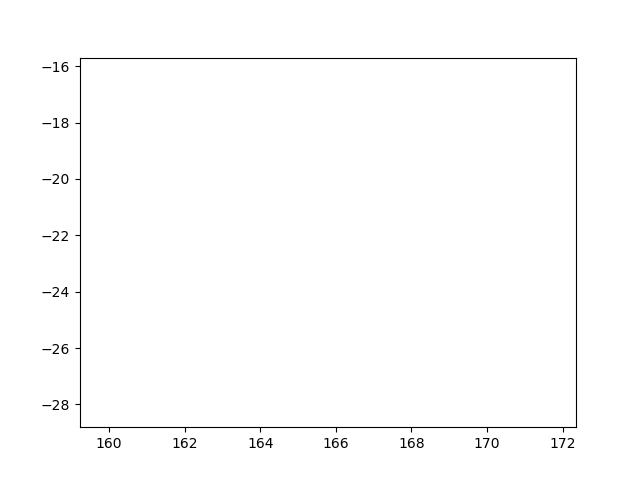

In [68]:
plt.figure()
plt.pcolormesh(interpolated_data.lon, interpolated_data.lat, interpolated_data)
plt.show()